# Решающие деревья

## Подготовка данных

In [13]:
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso
from sklearn.preprocessing import LabelEncoder, StandardScaler

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree, export_text
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import (accuracy_score, f1_score, confusion_matrix, classification_report,
                             r2_score, mean_absolute_error, mean_squared_error, roc_auc_score)
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [14]:
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import (accuracy_score, f1_score, confusion_matrix, classification_report,
                             r2_score, mean_absolute_error, mean_squared_error)
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

Предобработка для классификации

In [15]:
df_class = pd.read_csv('./data/beans/Dry_Bean_Dataset.csv')
df_reg = pd.read_csv('./data/football/players_3120.csv')


X_cls = df_class.drop('Class', axis=1)
y_cls = df_class['Class']

le = LabelEncoder()
y_cls_encoded = le.fit_transform(y_cls)

X_cls_train, X_cls_test, y_cls_train, y_cls_test = train_test_split(
    X_cls, y_cls_encoded, test_size=0.2, random_state=42, stratify=y_cls_encoded
)

scaler_cls = StandardScaler()
X_cls_train_scaled = scaler_cls.fit_transform(X_cls_train)
X_cls_test_scaled = scaler_cls.transform(X_cls_test)


Предобработка для регрессии

In [16]:

def value_to_float(value_str):
    try:
        if pd.isna(value_str):
            return np.nan
        
        value_str = str(value_str).strip()
        
        if value_str.startswith('€'):
            value_str = value_str[1:]
        
        multiplier = 1
        if value_str.endswith('M'):
            multiplier = 1_000_000
            value_str = value_str[:-1]
        elif value_str.endswith('K'):
            multiplier = 1_000
            value_str = value_str[:-1]
        
        return float(value_str) * multiplier
    except Exception as e:
        print(f"Ошибка преобразования '{value_str}': {e}")
        return np.nan


df_reg['Value_numeric'] = df_reg['Value'].apply(value_to_float)

def height_to_cm(height_str):
    try:
        if pd.isna(height_str):
            return np.nan
        height_str = str(height_str)
        import re
        match = re.search(r'(\d+)cm', height_str)
        if match:
            return float(match.group(1))
        return np.nan
    except:
        return np.nan

def weight_to_kg(weight_str):
    try:
        if pd.isna(weight_str):
            return np.nan
        weight_str = str(weight_str)
        import re
        match = re.search(r'(\d+)kg', weight_str)
        if match:
            return float(match.group(1))
        return np.nan
    except:
        return np.nan

df_reg['Height_cm'] = df_reg['Height'].apply(height_to_cm)
df_reg['Weight_kg'] = df_reg['Weight'].apply(weight_to_kg)

numeric_features = [
    'Age', 
    'Overall rating', 
    'Potential',
    'Height_cm',
    'Weight_kg',
    'Crossing', 
    'Finishing', 
    'Short passing', 
    'Dribbling',
    'Acceleration', 
    'Sprint speed', 
    'Stamina', 
    'Strength',
    'Long shots',
    'Interceptions',
    'Heading accuracy',
    'Ball control',
    'Reactions',
    'Composure',
    'Vision',
    'Aggression',
    'Penalties'
]

existing_features = [col for col in numeric_features if col in df_reg.columns]
print(f"\nИспользуем признаки ({len(existing_features)}): {existing_features}")

X_reg = df_reg[existing_features].copy()

for col in X_reg.columns:
    X_reg[col] = pd.to_numeric(X_reg[col], errors='coerce')

X_reg = X_reg.fillna(X_reg.median())

y_reg = df_reg['Value_numeric']

valid_indices = y_reg.notna()
X_reg = X_reg[valid_indices]
y_reg = y_reg[valid_indices]

X_reg_train, X_reg_test, y_reg_train, y_reg_test = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42
)

scaler_reg = StandardScaler()
X_reg_train_scaled = scaler_reg.fit_transform(X_reg_train)
X_reg_test_scaled = scaler_reg.transform(X_reg_test)


Используем признаки (22): ['Age', 'Overall rating', 'Potential', 'Height_cm', 'Weight_kg', 'Crossing', 'Finishing', 'Short passing', 'Dribbling', 'Acceleration', 'Sprint speed', 'Stamina', 'Strength', 'Long shots', 'Interceptions', 'Heading accuracy', 'Ball control', 'Reactions', 'Composure', 'Vision', 'Aggression', 'Penalties']


# 2.1 Классификация 

Обучение бейзлайна и оценка качества


КЛАССИФИКАЦИЯ: Решающее дерево (бейзлайн)
Accuracy (решающее дерево): 0.8810
F1-score (macro): 0.8847


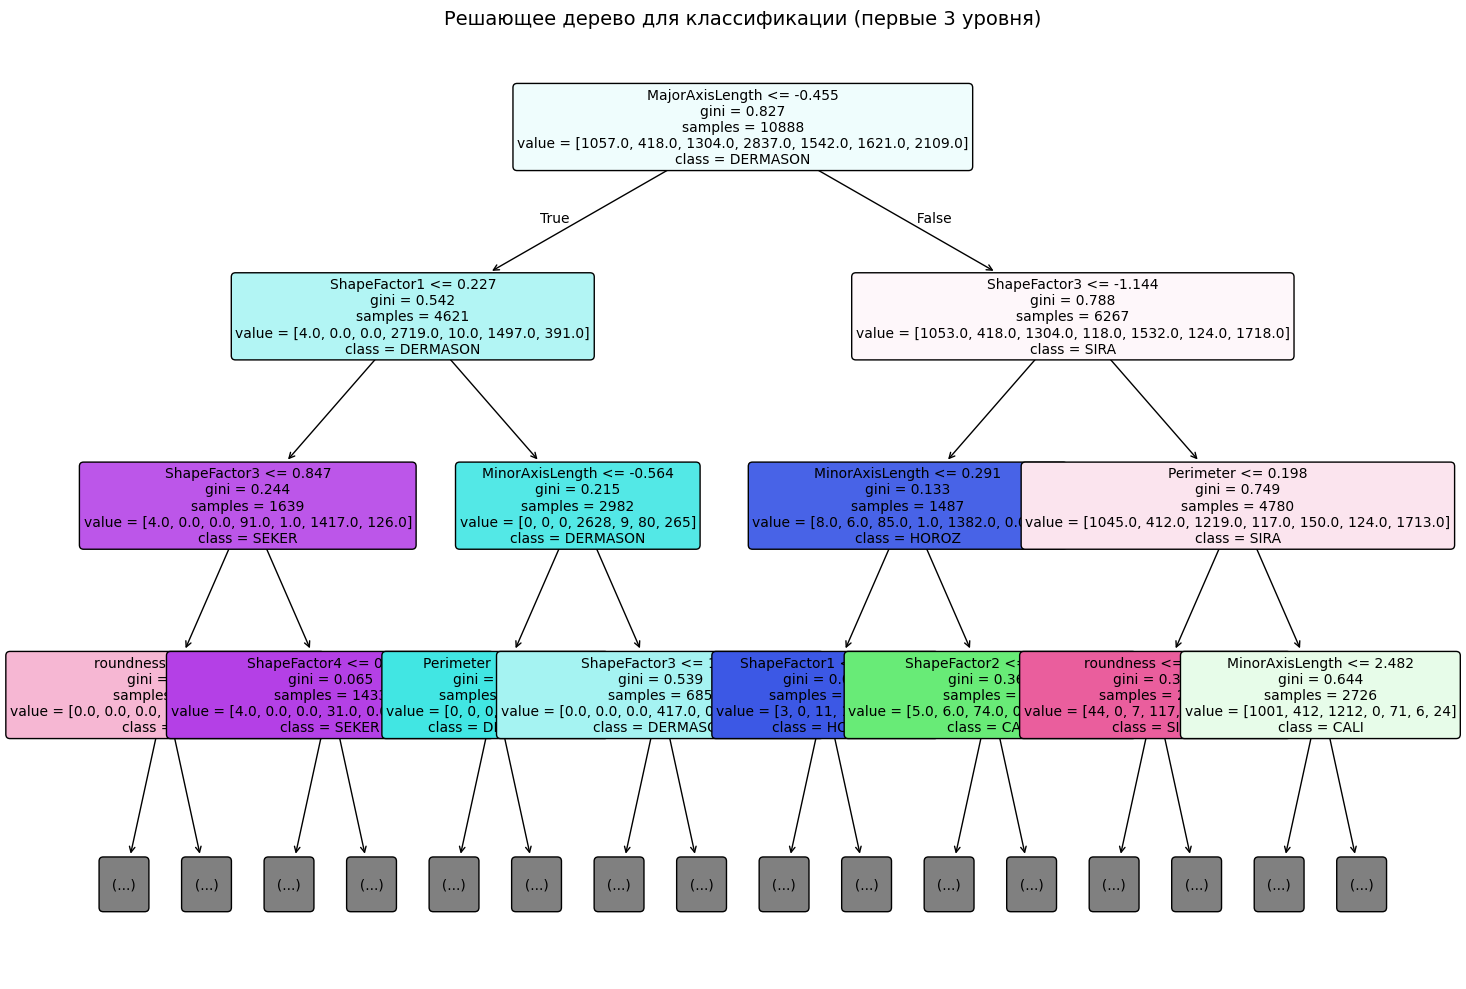


Топ-10 самых важных признаков для классификации:
            feature  importance
14     ShapeFactor3    0.262646
2   MajorAxisLength    0.219140
12     ShapeFactor1    0.205802
1         Perimeter    0.169635
3   MinorAxisLength    0.103748
10        roundness    0.032680
15     ShapeFactor4    0.002717
13     ShapeFactor2    0.001356
0              Area    0.000844
8            Extent    0.000699


In [17]:
print("\n" + "="*70)
print("КЛАССИФИКАЦИЯ: Решающее дерево (бейзлайн)")
print("="*70)

dt_cls_baseline = DecisionTreeClassifier(
    random_state=42,
    max_depth=5  # Ограничиваем глубину для предотвращения переобучения
)

dt_cls_baseline.fit(X_cls_train_scaled, y_cls_train)
y_cls_pred_dt = dt_cls_baseline.predict(X_cls_test_scaled)
y_cls_prob_dt = dt_cls_baseline.predict_proba(X_cls_test_scaled)

acc_dt_cls = accuracy_score(y_cls_test, y_cls_pred_dt)
f1_dt_cls = f1_score(y_cls_test, y_cls_pred_dt, average='macro')

print(f"Accuracy (решающее дерево): {acc_dt_cls:.4f}")
print(f"F1-score (macro): {f1_dt_cls:.4f}")

plt.figure(figsize=(15, 10))
plot_tree(dt_cls_baseline, 
          feature_names=X_cls.columns.tolist(),
          class_names=le.classes_.tolist(),
          filled=True, 
          rounded=True,
          max_depth=3,  
          fontsize=10)
plt.title("Решающее дерево для классификации (первые 3 уровня)", fontsize=14)
plt.tight_layout()
plt.show()

feature_importance_cls = pd.DataFrame({
    'feature': X_cls.columns,
    'importance': dt_cls_baseline.feature_importances_
}).sort_values('importance', ascending=False)

print("\nТоп-10 самых важных признаков для классификации:")
print(feature_importance_cls.head(10))

# 2.2 Регрессия 

Обучение бейзлайна и оценка качества

In [18]:
print("\n" + "="*70)
print("РЕГРЕССИЯ: Решающее дерево (бейзлайн)")
print("="*70)

dt_reg_baseline = DecisionTreeRegressor(
    random_state=42,
    max_depth=5
)

y_reg_train_log = np.log1p(y_reg_train)

dt_reg_baseline.fit(X_reg_train_scaled, y_reg_train_log)

y_reg_pred_log_dt = dt_reg_baseline.predict(X_reg_test_scaled)
y_reg_pred_dt = np.expm1(y_reg_pred_log_dt)

r2_dt_reg = r2_score(y_reg_test, y_reg_pred_dt)
mae_dt_reg = mean_absolute_error(y_reg_test, y_reg_pred_dt)
rmse_dt_reg = np.sqrt(mean_squared_error(y_reg_test, y_reg_pred_dt))

print(f"R² (решающее дерево): {r2_dt_reg:.4f}")
print(f"MAE: {mae_dt_reg:,.0f} евро ({mae_dt_reg/1_000_000:.2f} млн евро)")
print(f"RMSE: {rmse_dt_reg:,.0f} евро ({rmse_dt_reg/1_000_000:.2f} млн евро)")

feature_importance_reg = pd.DataFrame({
    'feature': X_reg.columns,
    'importance': dt_reg_baseline.feature_importances_
}).sort_values('importance', ascending=False)

print("\nТоп-10 самых важных признаков для регрессии:")
print(feature_importance_reg.head(10))


РЕГРЕССИЯ: Решающее дерево (бейзлайн)
R² (решающее дерево): 0.5431
MAE: 5,296,249 евро (5.30 млн евро)
RMSE: 11,267,496 евро (11.27 млн евро)

Топ-10 самых важных признаков для регрессии:
          feature  importance
17      Reactions    0.310438
2       Potential    0.239985
0             Age    0.115257
9    Acceleration    0.061126
18      Composure    0.059311
7   Short passing    0.052732
14  Interceptions    0.046626
20     Aggression    0.031998
11        Stamina    0.029927
3       Height_cm    0.021736


# 3. Улучшение бейзлайна

## Формулировка гипотез:

### Для классификации:

H1: Оптимизация глубины дерева (max_depth) предотвратит переобучение.

H2: Настройка минимального количества образцов в листе (min_samples_leaf) улучшит обобщающую способность.

H3: Использование критерия Джини (gini) вместо энтропии (entropy) может дать лучшие результаты.

H4: Применение случайного леса (ансамбль деревьев) значительно улучшит качество.

Обучение улучшенного бейзлайна и оценка качества

In [19]:
print("\n" + "="*70)
print("3. УЛУЧШЕНИЕ БЕЙЗЛАЙНА ДЛЯ РЕШАЮЩИХ ДЕРЕВЬЕВ")
print("="*70)

print("\n" + "-"*70)
print("КЛАССИФИКАЦИЯ: Улучшение решающего дерева")
print("-"*70)

param_grid_dt_cls = {
    'max_depth': [3, 5, 7, 10, 15, 20, None],  # H1: Глубина дерева
    'min_samples_split': [2, 5, 10, 20],  # Минимальное количество для разделения
    'min_samples_leaf': [1, 2, 4, 8, 10],  # H2: Минимальное количество в листе
    'criterion': ['gini', 'entropy'],  # H3: Критерий разделения
    'max_features': ['sqrt', 'log2', None]  # Количество признаков для разделения
}

grid_search_dt_cls = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid_dt_cls,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=1
)

grid_search_dt_cls.fit(X_cls_train_scaled, y_cls_train)

print(f"\nЛучшие параметры решающего дерева (классификация):")
print(f"  max_depth: {grid_search_dt_cls.best_params_['max_depth']}")
print(f"  min_samples_split: {grid_search_dt_cls.best_params_['min_samples_split']}")
print(f"  min_samples_leaf: {grid_search_dt_cls.best_params_['min_samples_leaf']}")
print(f"  criterion: {grid_search_dt_cls.best_params_['criterion']}")
print(f"  max_features: {grid_search_dt_cls.best_params_['max_features']}")

dt_cls_improved = grid_search_dt_cls.best_estimator_
y_cls_pred_dt_imp = dt_cls_improved.predict(X_cls_test_scaled)

acc_dt_cls_imp = accuracy_score(y_cls_test, y_cls_pred_dt_imp)
f1_dt_cls_imp = f1_score(y_cls_test, y_cls_pred_dt_imp, average='macro')

print(f"\nРезультаты улучшенного решающего дерева (классификация):")
print(f"Accuracy: {acc_dt_cls_imp:.4f}")
print(f"F1-score (macro): {f1_dt_cls_imp:.4f}")

# H4: Случайный лес
print("\n" + "-"*70)
print("КЛАССИФИКАЦИЯ: Случайный лес (ансамбль)")
print("-"*70)

rf_cls = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)

param_grid_rf_cls = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_leaf': [1, 2, 4]
}

grid_search_rf_cls = GridSearchCV(
    rf_cls,
    param_grid_rf_cls,
    cv=3,  # Уменьшаем cv для скорости
    scoring='f1_macro',
    n_jobs=-1,
    verbose=1
)

grid_search_rf_cls.fit(X_cls_train_scaled, y_cls_train)

rf_cls_improved = grid_search_rf_cls.best_estimator_
y_cls_pred_rf = rf_cls_improved.predict(X_cls_test_scaled)

acc_rf_cls = accuracy_score(y_cls_test, y_cls_pred_rf)
f1_rf_cls = f1_score(y_cls_test, y_cls_pred_rf, average='macro')

print(f"Результаты случайного леса (классификация):")
print(f"Accuracy: {acc_rf_cls:.4f}")
print(f"F1-score (macro): {f1_rf_cls:.4f}")


3. УЛУЧШЕНИЕ БЕЙЗЛАЙНА ДЛЯ РЕШАЮЩИХ ДЕРЕВЬЕВ

----------------------------------------------------------------------
КЛАССИФИКАЦИЯ: Улучшение решающего дерева
----------------------------------------------------------------------
Fitting 5 folds for each of 840 candidates, totalling 4200 fits

Лучшие параметры решающего дерева (классификация):
  max_depth: 10
  min_samples_split: 2
  min_samples_leaf: 10
  criterion: entropy
  max_features: None

Результаты улучшенного решающего дерева (классификация):
Accuracy: 0.9034
F1-score (macro): 0.9169

----------------------------------------------------------------------
КЛАССИФИКАЦИЯ: Случайный лес (ансамбль)
----------------------------------------------------------------------
Fitting 3 folds for each of 27 candidates, totalling 81 fits
Результаты случайного леса (классификация):
Accuracy: 0.9214
F1-score (macro): 0.9339


### Для регрессии:

H1: Настройка max_depth и min_samples_split улучшит качество регрессии.

H2: Использование min_samples_leaf уменьшит дисперсию предсказаний.

H3: Критерий friedman_mse может работать лучше, чем mse по умолчанию.


H4: Случайный лес для регрессии даст лучшие результаты, чем одиночное дерево.

In [20]:
print("\n" + "-"*70)
print("РЕГРЕССИЯ: Улучшение решающего дерева")
print("-"*70)

param_grid_dt_reg = {
    'max_depth': [3, 5, 7, 10, 15, 20, None],  # H1: Глубина дерева
    'min_samples_split': [2, 5, 10, 20],  # H1: Минимальное для разделения
    'min_samples_leaf': [1, 2, 4, 8, 10],  # H2: Минимальное в листе
    'criterion': ['squared_error', 'friedman_mse', 'absolute_error'],  # H3: Критерий
    'max_features': ['sqrt', 'log2', None]  # Признаки для разделения
}

grid_search_dt_reg = GridSearchCV(
    DecisionTreeRegressor(random_state=42),
    param_grid_dt_reg,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

grid_search_dt_reg.fit(X_reg_train_scaled, y_reg_train_log)

print(f"\nЛучшие параметры решающего дерева (регрессия):")
print(f"  max_depth: {grid_search_dt_reg.best_params_['max_depth']}")
print(f"  min_samples_split: {grid_search_dt_reg.best_params_['min_samples_split']}")
print(f"  min_samples_leaf: {grid_search_dt_reg.best_params_['min_samples_leaf']}")
print(f"  criterion: {grid_search_dt_reg.best_params_['criterion']}")
print(f"  max_features: {grid_search_dt_reg.best_params_['max_features']}")

dt_reg_improved = grid_search_dt_reg.best_estimator_
y_reg_pred_log_dt_imp = dt_reg_improved.predict(X_reg_test_scaled)
y_reg_pred_dt_imp = np.expm1(y_reg_pred_log_dt_imp)

r2_dt_reg_imp = r2_score(y_reg_test, y_reg_pred_dt_imp)
mae_dt_reg_imp = mean_absolute_error(y_reg_test, y_reg_pred_dt_imp)
rmse_dt_reg_imp = np.sqrt(mean_squared_error(y_reg_test, y_reg_pred_dt_imp))

print(f"\nРезультаты улучшенного решающего дерева (регрессия):")
print(f"R²: {r2_dt_reg_imp:.4f}")
print(f"MAE: {mae_dt_reg_imp:,.0f} евро ({mae_dt_reg_imp/1_000_000:.2f} млн евро)")
print(f"RMSE: {rmse_dt_reg_imp:,.0f} евро ({rmse_dt_reg_imp/1_000_000:.2f} млн евро)")

# H4: Случайный лес для регрессии
print("\n" + "-"*70)
print("РЕГРЕССИЯ: Случайный лес (ансамбль)")
print("-"*70)

rf_reg = RandomForestRegressor(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)

param_grid_rf_reg = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_leaf': [1, 2, 4]
}

grid_search_rf_reg = GridSearchCV(
    rf_reg,
    param_grid_rf_reg,
    cv=3,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

grid_search_rf_reg.fit(X_reg_train_scaled, y_reg_train_log)

rf_reg_improved = grid_search_rf_reg.best_estimator_
y_reg_pred_log_rf = rf_reg_improved.predict(X_reg_test_scaled)
y_reg_pred_rf = np.expm1(y_reg_pred_log_rf)

r2_rf_reg = r2_score(y_reg_test, y_reg_pred_rf)
mae_rf_reg = mean_absolute_error(y_reg_test, y_reg_pred_rf)
rmse_rf_reg = np.sqrt(mean_squared_error(y_reg_test, y_reg_pred_rf))

print(f"Результаты случайного леса (регрессия):")
print(f"R²: {r2_rf_reg:.4f}")
print(f"MAE: {mae_rf_reg:,.0f} евро ({mae_rf_reg/1_000_000:.2f} млн евро)")
print(f"RMSE: {rmse_rf_reg:,.0f} евро ({rmse_rf_reg/1_000_000:.2f} млн евро)")


----------------------------------------------------------------------
РЕГРЕССИЯ: Улучшение решающего дерева
----------------------------------------------------------------------
Fitting 5 folds for each of 1260 candidates, totalling 6300 fits

Лучшие параметры решающего дерева (регрессия):
  max_depth: 10
  min_samples_split: 2
  min_samples_leaf: 8
  criterion: absolute_error
  max_features: None

Результаты улучшенного решающего дерева (регрессия):
R²: 0.8643
MAE: 2,225,258 евро (2.23 млн евро)
RMSE: 6,141,354 евро (6.14 млн евро)

----------------------------------------------------------------------
РЕГРЕССИЯ: Случайный лес (ансамбль)
----------------------------------------------------------------------
Fitting 3 folds for each of 27 candidates, totalling 81 fits
Результаты случайного леса (регрессия):
R²: 0.8416
MAE: 2,282,311 евро (2.28 млн евро)
RMSE: 6,633,887 евро (6.63 млн евро)


Сравнение результатов и визуализация


СРАВНЕНИЕ: БЕЙЗЛАЙН vs УЛУЧШЕННЫЕ МОДЕЛИ ДЕРЕВЬЕВ

Модель (классификация)              Accuracy        F1-score        Улучшение F1   
----------------------------------- --------------- --------------- ---------------
Дерево (бейзлайн)                   0.8810          0.8847          -              
Дерево (улучшенное)                 0.9034          0.9169          +0.0323        
Случайный лес                       0.9214          0.9339          +0.0492        

Модель (регрессия)                  R²              MAE (млн €)     Улучшение R²   
----------------------------------- --------------- --------------- ---------------
Дерево (бейзлайн)                   0.5431          5.30            -              
Дерево (улучшенное)                 0.8643          2.23            +0.3212        
Случайный лес                       0.8416          2.28            +0.2985        


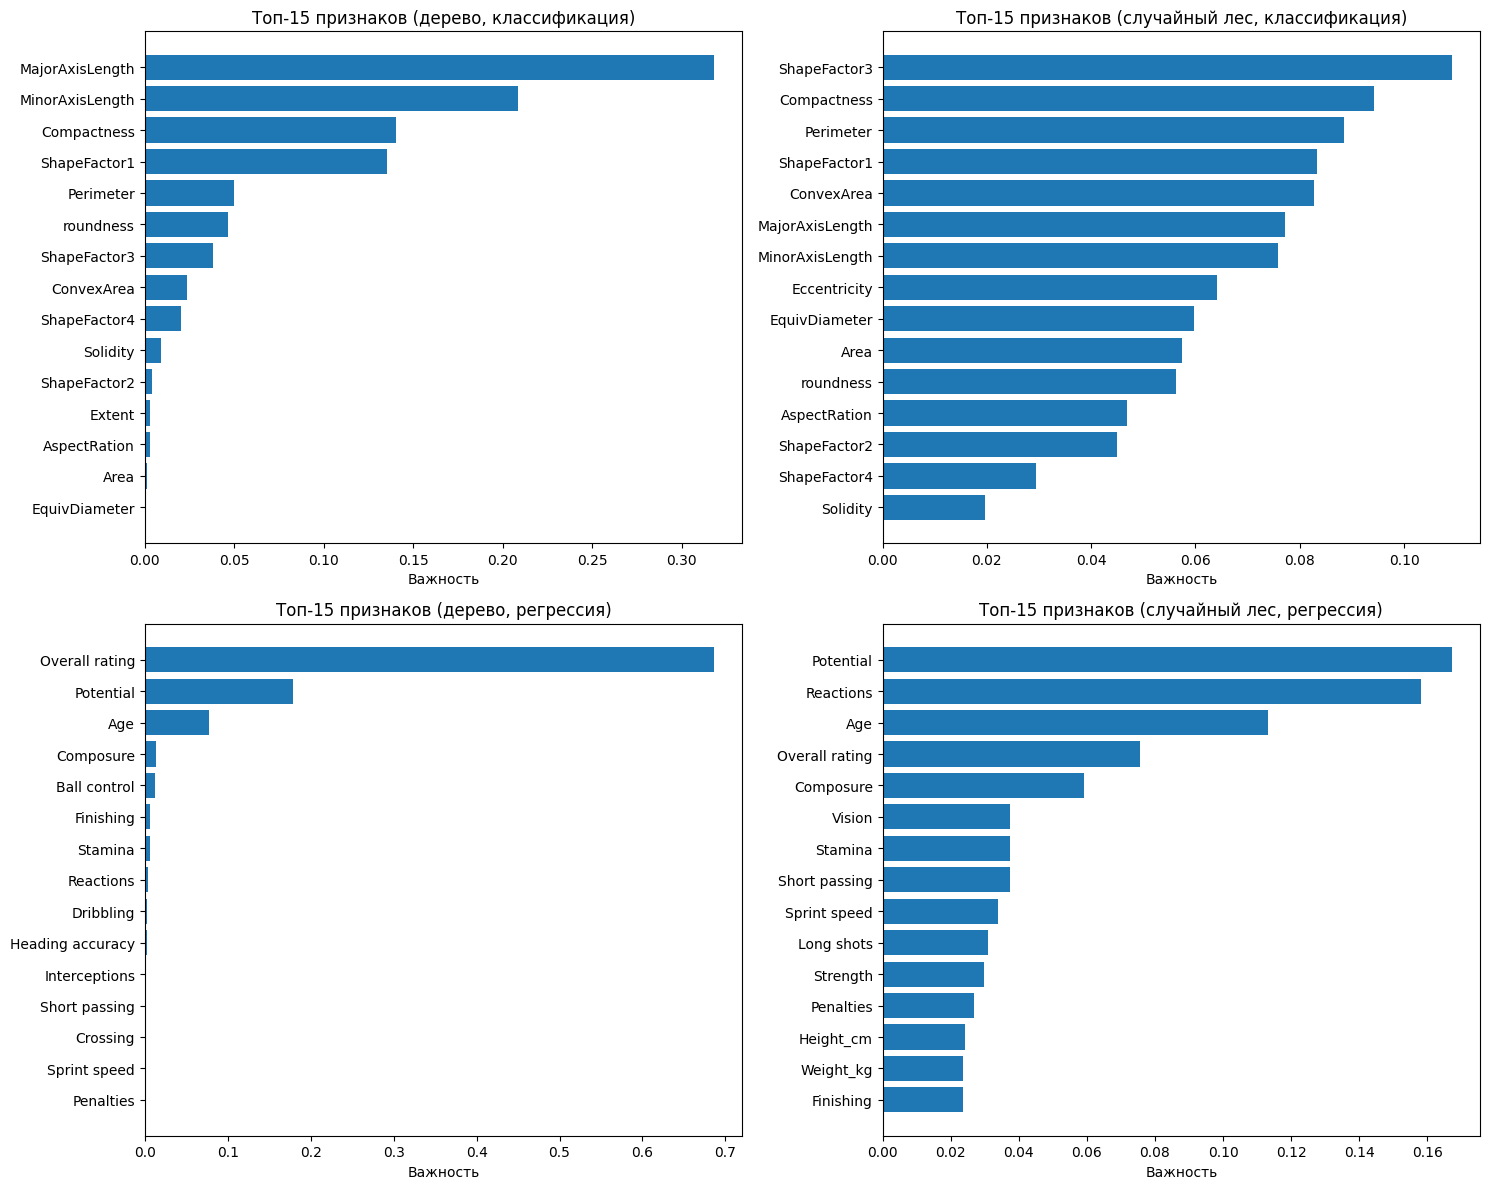

In [21]:
print("\n" + "="*70)
print("СРАВНЕНИЕ: БЕЙЗЛАЙН vs УЛУЧШЕННЫЕ МОДЕЛИ ДЕРЕВЬЕВ")
print("="*70)

print(f"\n{'Модель (классификация)':<35} {'Accuracy':<15} {'F1-score':<15} {'Улучшение F1':<15}")
print(f"{'-'*35:<35} {'-'*15:<15} {'-'*15:<15} {'-'*15:<15}")

print(f"{'Дерево (бейзлайн)':<35} {acc_dt_cls:<15.4f} {f1_dt_cls:<15.4f} {'-':<15}")
print(f"{'Дерево (улучшенное)':<35} {acc_dt_cls_imp:<15.4f} {f1_dt_cls_imp:<15.4f} {f1_dt_cls_imp - f1_dt_cls:<+15.4f}")
print(f"{'Случайный лес':<35} {acc_rf_cls:<15.4f} {f1_rf_cls:<15.4f} {f1_rf_cls - f1_dt_cls:<+15.4f}")

print(f"\n{'Модель (регрессия)':<35} {'R²':<15} {'MAE (млн €)':<15} {'Улучшение R²':<15}")
print(f"{'-'*35:<35} {'-'*15:<15} {'-'*15:<15} {'-'*15:<15}")

print(f"{'Дерево (бейзлайн)':<35} {r2_dt_reg:<15.4f} {mae_dt_reg/1_000_000:<15.2f} {'-':<15}")
print(f"{'Дерево (улучшенное)':<35} {r2_dt_reg_imp:<15.4f} {mae_dt_reg_imp/1_000_000:<15.2f} {r2_dt_reg_imp - r2_dt_reg:<+15.4f}")
print(f"{'Случайный лес':<35} {r2_rf_reg:<15.4f} {mae_rf_reg/1_000_000:<15.2f} {r2_rf_reg - r2_dt_reg:<+15.4f}")

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

importance_cls_tree = pd.DataFrame({
    'feature': X_cls.columns,
    'importance': dt_cls_improved.feature_importances_
}).sort_values('importance', ascending=False).head(15)

axes[0, 0].barh(range(len(importance_cls_tree)), importance_cls_tree['importance'])
axes[0, 0].set_yticks(range(len(importance_cls_tree)))
axes[0, 0].set_yticklabels(importance_cls_tree['feature'])
axes[0, 0].invert_yaxis()
axes[0, 0].set_xlabel('Важность')
axes[0, 0].set_title('Топ-15 признаков (дерево, классификация)')

# Важность признаков для классификации (лес)
importance_cls_rf = pd.DataFrame({
    'feature': X_cls.columns,
    'importance': rf_cls_improved.feature_importances_
}).sort_values('importance', ascending=False).head(15)

axes[0, 1].barh(range(len(importance_cls_rf)), importance_cls_rf['importance'])
axes[0, 1].set_yticks(range(len(importance_cls_rf)))
axes[0, 1].set_yticklabels(importance_cls_rf['feature'])
axes[0, 1].invert_yaxis()
axes[0, 1].set_xlabel('Важность')
axes[0, 1].set_title('Топ-15 признаков (случайный лес, классификация)')

importance_reg_tree = pd.DataFrame({
    'feature': X_reg.columns,
    'importance': dt_reg_improved.feature_importances_
}).sort_values('importance', ascending=False).head(15)

axes[1, 0].barh(range(len(importance_reg_tree)), importance_reg_tree['importance'])
axes[1, 0].set_yticks(range(len(importance_reg_tree)))
axes[1, 0].set_yticklabels(importance_reg_tree['feature'])
axes[1, 0].invert_yaxis()
axes[1, 0].set_xlabel('Важность')
axes[1, 0].set_title('Топ-15 признаков (дерево, регрессия)')

importance_reg_rf = pd.DataFrame({
    'feature': X_reg.columns,
    'importance': rf_reg_improved.feature_importances_
}).sort_values('importance', ascending=False).head(15)

axes[1, 1].barh(range(len(importance_reg_rf)), importance_reg_rf['importance'])
axes[1, 1].set_yticks(range(len(importance_reg_rf)))
axes[1, 1].set_yticklabels(importance_reg_rf['feature'])
axes[1, 1].invert_yaxis()
axes[1, 1].set_xlabel('Важность')
axes[1, 1].set_title('Топ-15 признаков (случайный лес, регрессия)')

plt.tight_layout()
plt.show()

# Имплеминтация

In [22]:
class MyDecisionTreeNode:
    """Узел решающего дерева"""
    def __init__(self, feature_idx=None, threshold=None, value=None, left=None, right=None):
        self.feature_idx = feature_idx  
        self.threshold = threshold      
        self.value = value              
        self.left = left                
        self.right = right              

class MyDecisionTreeClassifier:
    """
    Собственная реализация решающего дерева для классификации
    """
    def __init__(self, max_depth=None, min_samples_split=2, min_samples_leaf=1, criterion='gini'):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.criterion = criterion
        self.tree = None
        self.n_classes = None
        
    def _gini(self, y):
        """Вычисление индекса Джини"""
        _, counts = np.unique(y, return_counts=True)
        probabilities = counts / len(y)
        return 1 - np.sum(probabilities ** 2)
    
    def _entropy(self, y):
        """Вычисление энтропии"""
        _, counts = np.unique(y, return_counts=True)
        probabilities = counts / len(y)
        return -np.sum(probabilities * np.log2(probabilities + 1e-10))
    
    def _information_gain(self, y, y_left, y_right, criterion):
        """Вычисление прироста информации"""
        if criterion == 'gini':
            parent_impurity = self._gini(y)
            left_impurity = self._gini(y_left)
            right_impurity = self._gini(y_right)
        else:  # entropy
            parent_impurity = self._entropy(y)
            left_impurity = self._entropy(y_left)
            right_impurity = self._entropy(y_right)
            
        n = len(y)
        n_left = len(y_left)
        n_right = len(y_right)
        
        gain = parent_impurity - (n_left/n) * left_impurity - (n_right/n) * right_impurity
        return gain
    
    def _best_split(self, X, y):
        """Нахождение лучшего разделения"""
        best_gain = -1
        best_feature = None
        best_threshold = None
        
        n_samples, n_features = X.shape
        
        for feature_idx in range(n_features):
            thresholds = np.unique(X[:, feature_idx])
            
            for threshold in thresholds:
                left_mask = X[:, feature_idx] <= threshold
                right_mask = ~left_mask
                
                if np.sum(left_mask) < self.min_samples_leaf or np.sum(right_mask) < self.min_samples_leaf:
                    continue
                
                gain = self._information_gain(y, y[left_mask], y[right_mask], self.criterion)
                
                if gain > best_gain:
                    best_gain = gain
                    best_feature = feature_idx
                    best_threshold = threshold
        
        return best_feature, best_threshold, best_gain
    
    def _build_tree(self, X, y, depth=0):
        """Рекурсивное построение дерева"""
        n_samples = len(y)
        
        if (self.max_depth is not None and depth >= self.max_depth) or \
           n_samples < self.min_samples_split or \
           len(np.unique(y)) == 1:
            
            values, counts = np.unique(y, return_counts=True)
            value = values[np.argmax(counts)]
            return MyDecisionTreeNode(value=value)
        
        feature_idx, threshold, gain = self._best_split(X, y)
        
        if feature_idx is None or gain <= 0:
            values, counts = np.unique(y, return_counts=True)
            value = values[np.argmax(counts)]
            return MyDecisionTreeNode(value=value)
        
        left_mask = X[:, feature_idx] <= threshold
        right_mask = ~left_mask
        
        left_subtree = self._build_tree(X[left_mask], y[left_mask], depth + 1)
        right_subtree = self._build_tree(X[right_mask], y[right_mask], depth + 1)
        
        return MyDecisionTreeNode(
            feature_idx=feature_idx,
            threshold=threshold,
            left=left_subtree,
            right=right_subtree
        )
    
    def fit(self, X, y):
        """Обучение дерева"""
        self.n_classes = len(np.unique(y))
        self.tree = self._build_tree(np.array(X), np.array(y))
        return self
    
    def _predict_one(self, x, node):
        """Рекурсивное предсказание для одного образца"""
        if node.value is not None:
            return node.value
        
        if x[node.feature_idx] <= node.threshold:
            return self._predict_one(x, node.left)
        else:
            return self._predict_one(x, node.right)
    
    def predict(self, X):
        """Предсказание для множества образцов"""
        return np.array([self._predict_one(x, self.tree) for x in X])
    
    def predict_proba(self, X):
        """Вероятности классов (упрощенная версия)"""
        predictions = self.predict(X)
        proba = np.zeros((len(X), self.n_classes))
        
        for i, pred in enumerate(predictions):
            proba[i, pred] = 1.0
            
        return proba


class MyDecisionTreeRegressor:
    """
    Собственная реализация решающего дерева для регрессии
    """
    def __init__(self, max_depth=None, min_samples_split=2, min_samples_leaf=1, criterion='mse'):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.criterion = criterion
        self.tree = None
        
    def _mse(self, y):
        """Среднеквадратичная ошибка"""
        if len(y) == 0:
            return 0
        return np.mean((y - np.mean(y)) ** 2)
    
    def _mae(self, y):
        """Средняя абсолютная ошибка"""
        if len(y) == 0:
            return 0
        return np.mean(np.abs(y - np.mean(y)))
    
    def _variance_reduction(self, y, y_left, y_right):
        """Уменьшение дисперсии/ошибки"""
        if self.criterion == 'mse':
            parent_error = self._mse(y)
            left_error = self._mse(y_left)
            right_error = self._mse(y_right)
        else:  # mae
            parent_error = self._mae(y)
            left_error = self._mae(y_left)
            right_error = self._mae(y_right)
            
        n = len(y)
        n_left = len(y_left)
        n_right = len(y_right)
        
        reduction = parent_error - (n_left/n) * left_error - (n_right/n) * right_error
        return reduction
    
    def _best_split_reg(self, X, y):
        """Нахождение лучшего разделения для регрессии"""
        best_reduction = -1
        best_feature = None
        best_threshold = None
        
        n_samples, n_features = X.shape
        
        for feature_idx in range(n_features):
            thresholds = np.unique(X[:, feature_idx])
            
            for threshold in thresholds:
                left_mask = X[:, feature_idx] <= threshold
                right_mask = ~left_mask
                
                if np.sum(left_mask) < self.min_samples_leaf or np.sum(right_mask) < self.min_samples_leaf:
                    continue
                
                reduction = self._variance_reduction(y, y[left_mask], y[right_mask])
                
                if reduction > best_reduction:
                    best_reduction = reduction
                    best_feature = feature_idx
                    best_threshold = threshold
        
        return best_feature, best_threshold, best_reduction
    
    def _build_tree_reg(self, X, y, depth=0):
        """Рекурсивное построение дерева регрессии"""
        n_samples = len(y)
        
        if (self.max_depth is not None and depth >= self.max_depth) or \
           n_samples < self.min_samples_split or \
           np.std(y) < 0.01:  
            
            value = np.mean(y)
            return MyDecisionTreeNode(value=value)
        
        feature_idx, threshold, reduction = self._best_split_reg(X, y)
        
        if feature_idx is None or reduction <= 0:
            value = np.mean(y)
            return MyDecisionTreeNode(value=value)
        
        left_mask = X[:, feature_idx] <= threshold
        right_mask = ~left_mask
        
        left_subtree = self._build_tree_reg(X[left_mask], y[left_mask], depth + 1)
        right_subtree = self._build_tree_reg(X[right_mask], y[right_mask], depth + 1)
        
        return MyDecisionTreeNode(
            feature_idx=feature_idx,
            threshold=threshold,
            left=left_subtree,
            right=right_subtree
        )
    
    def fit(self, X, y):
        """Обучение дерева регрессии"""
        self.tree = self._build_tree_reg(np.array(X), np.array(y))
        return self
    
    def _predict_one_reg(self, x, node):
        """Рекурсивное предсказание для одного образца"""
        if node.value is not None:
            return node.value
        
        if x[node.feature_idx] <= node.threshold:
            return self._predict_one_reg(x, node.left)
        else:
            return self._predict_one_reg(x, node.right)
    
    def predict(self, X):
        """Предсказание для множества образцов"""
        X_array = np.array(X)
        n_samples = X_array.shape[0]
        predictions = np.zeros(n_samples, dtype=float)
        
        for i in range(n_samples):
            predictions[i] = self._predict_one_reg(X_array[i], self.tree)
        
        return predictions

 ### Бейзлайн и собственная реализация 

Обучение собственной модели и оценка (классификация)

In [23]:
print("\n" + "-"*70)
print("КЛАССИФИКАЦИЯ: Собственное решающее дерево")
print("-"*70)

my_dt_cls = MyDecisionTreeClassifier(
    max_depth=5,
    min_samples_split=10,
    min_samples_leaf=5,
    criterion='gini'
)

my_dt_cls.fit(X_cls_train_scaled, y_cls_train)
y_cls_pred_my_dt = my_dt_cls.predict(X_cls_test_scaled)


acc_my_dt_cls = accuracy_score(y_cls_test, y_cls_pred_my_dt)
f1_my_dt_cls = f1_score(y_cls_test, y_cls_pred_my_dt, average='macro')

print("Результаты собственного решающего дерева (классификация):")
print(f"Accuracy: {acc_my_dt_cls:.4f}")
print(f"F1-score (macro): {f1_my_dt_cls:.4f}")

print(f"\nСравнение с sklearn DecisionTreeClassifier:")
print(f"  sklearn Accuracy: {acc_dt_cls:.4f}")
print(f"  Наша Accuracy: {acc_my_dt_cls:.4f}")
print(f"  Разница: {acc_my_dt_cls - acc_dt_cls:+.4f}")


----------------------------------------------------------------------
КЛАССИФИКАЦИЯ: Собственное решающее дерево
----------------------------------------------------------------------
Результаты собственного решающего дерева (классификация):
Accuracy: 0.8806
F1-score (macro): 0.8844

Сравнение с sklearn DecisionTreeClassifier:
  sklearn Accuracy: 0.8810
  Наша Accuracy: 0.8806
  Разница: -0.0004


Обучение собственной модели и оценка (регрессия)

In [24]:
print("\n" + "-"*70)
print("РЕГРЕССИЯ: Собственное решающее дерево")
print("-"*70)

my_dt_reg = MyDecisionTreeRegressor(
    max_depth=5,
    min_samples_split=10,
    min_samples_leaf=5,
    criterion='mse'
)

my_dt_reg.fit(X_reg_train_scaled, y_reg_train_log)

y_reg_pred_log_my_dt = my_dt_reg.predict(X_reg_test_scaled)
y_reg_pred_my_dt = np.expm1(y_reg_pred_log_my_dt)

r2_my_dt_reg = r2_score(y_reg_test, y_reg_pred_my_dt)
mae_my_dt_reg = mean_absolute_error(y_reg_test, y_reg_pred_my_dt)
rmse_my_dt_reg = np.sqrt(mean_squared_error(y_reg_test, y_reg_pred_my_dt))

print("Результаты собственного решающего дерева (регрессия):")
print(f"R²: {r2_my_dt_reg:.4f}")
print(f"MAE: {mae_my_dt_reg:,.0f} евро ({mae_my_dt_reg/1_000_000:.2f} млн евро)")
print(f"RMSE: {rmse_my_dt_reg:,.0f} евро ({rmse_my_dt_reg/1_000_000:.2f} млн евро)")

print(f"\nСравнение с sklearn DecisionTreeRegressor:")
print(f"  sklearn R²: {r2_dt_reg:.4f}")
print(f"  Наша R²: {r2_my_dt_reg:.4f}")
print(f"  Разница: {r2_my_dt_reg - r2_dt_reg:+.4f}")


----------------------------------------------------------------------
РЕГРЕССИЯ: Собственное решающее дерево
----------------------------------------------------------------------
Результаты собственного решающего дерева (регрессия):
R²: 0.5410
MAE: 5,254,819 евро (5.25 млн евро)
RMSE: 11,292,980 евро (11.29 млн евро)

Сравнение с sklearn DecisionTreeRegressor:
  sklearn R²: 0.5431
  Наша R²: 0.5410
  Разница: -0.0021


### Добавление техник улучшенного бейзлайна:

Обучение собственной модели и оценка (классификация)

In [25]:
print("\n" + "-"*70)
print("КЛАССИФИКАЦИЯ: Собственная реализация с улучшениями")
print("-"*70)

if 'grid_search_dt_cls' in locals():
    best_params_dt_cls = grid_search_dt_cls.best_params_
    print(f"Используем параметры из улучшенного бейзлайна:")
    print(f"  max_depth: {best_params_dt_cls.get('max_depth', 'Не определен')}")
    print(f"  min_samples_split: {best_params_dt_cls.get('min_samples_split', 'Не определен')}")
    print(f"  min_samples_leaf: {best_params_dt_cls.get('min_samples_leaf', 'Не определен')}")
    print(f"  criterion: {best_params_dt_cls.get('criterion', 'Не определен')}")
    
    my_dt_cls_improved = MyDecisionTreeClassifier(
        max_depth=best_params_dt_cls.get('max_depth', 10),
        min_samples_split=best_params_dt_cls.get('min_samples_split', 10),
        min_samples_leaf=best_params_dt_cls.get('min_samples_leaf', 5),
        criterion=best_params_dt_cls.get('criterion', 'gini')
    )
else:
    print("Используем параметры из бейзлайна (GridSearch не выполнен)")
    my_dt_cls_improved = MyDecisionTreeClassifier(
        max_depth=10,
        min_samples_split=10,
        min_samples_leaf=5,
        criterion='gini'
    )

my_dt_cls_improved.fit(X_cls_train_scaled, y_cls_train)
y_cls_pred_my_dt_imp = my_dt_cls_improved.predict(X_cls_test_scaled)

acc_my_dt_cls_imp = accuracy_score(y_cls_test, y_cls_pred_my_dt_imp)
f1_my_dt_cls_imp = f1_score(y_cls_test, y_cls_pred_my_dt_imp, average='macro')

print(f"\nРезультаты улучшенного собственного решающего дерева:")
print(f"Accuracy: {acc_my_dt_cls_imp:.4f}")
print(f"F1-score (macro): {f1_my_dt_cls_imp:.4f}")


----------------------------------------------------------------------
КЛАССИФИКАЦИЯ: Собственная реализация с улучшениями
----------------------------------------------------------------------
Используем параметры из улучшенного бейзлайна:
  max_depth: 10
  min_samples_split: 2
  min_samples_leaf: 10
  criterion: entropy

Результаты улучшенного собственного решающего дерева:
Accuracy: 0.9034
F1-score (macro): 0.9169


Обучение собственной модели и оценка (регрессия)

In [26]:
print("\n" + "-"*70)
print("РЕГРЕССИЯ: Собственная реализация с улучшениями")
print("-"*70)

if 'grid_search_dt_reg' in locals():
    best_params_dt_reg = grid_search_dt_reg.best_params_
    print(f"Используем параметры из улучшенного бейзлайна:")
    print(f"  max_depth: {best_params_dt_reg.get('max_depth', 'Не определен')}")
    print(f"  min_samples_split: {best_params_dt_reg.get('min_samples_split', 'Не определен')}")
    print(f"  min_samples_leaf: {best_params_dt_reg.get('min_samples_leaf', 'Не определен')}")
    print(f"  criterion: {best_params_dt_reg.get('criterion', 'Не определен')}")
    
    my_dt_reg_improved = MyDecisionTreeRegressor(
        max_depth=best_params_dt_reg.get('max_depth', 10),
        min_samples_split=best_params_dt_reg.get('min_samples_split', 10),
        min_samples_leaf=best_params_dt_reg.get('min_samples_leaf', 5),
        criterion='mse'  
    )
else:
    print("Используем параметры из бейзлайна (GridSearch не выполнен)")
    my_dt_reg_improved = MyDecisionTreeRegressor(
        max_depth=10,
        min_samples_split=10,
        min_samples_leaf=5,
        criterion='mse'
    )

my_dt_reg_improved.fit(X_reg_train_scaled, y_reg_train_log)

y_reg_pred_log_my_dt_imp = my_dt_reg_improved.predict(X_reg_test_scaled)
y_reg_pred_my_dt_imp = np.expm1(y_reg_pred_log_my_dt_imp)

r2_my_dt_reg_imp = r2_score(y_reg_test, y_reg_pred_my_dt_imp)
mae_my_dt_reg_imp = mean_absolute_error(y_reg_test, y_reg_pred_my_dt_imp)
rmse_my_dt_reg_imp = np.sqrt(mean_squared_error(y_reg_test, y_reg_pred_my_dt_imp))

print(f"\nРезультаты улучшенного собственного решающего дерева:")
print(f"R²: {r2_my_dt_reg_imp:.4f}")
print(f"MAE: {mae_my_dt_reg_imp:,.0f} евро ({mae_my_dt_reg_imp/1_000_000:.2f} млн евро)")
print(f"RMSE: {rmse_my_dt_reg_imp:,.0f} евро ({rmse_my_dt_reg_imp/1_000_000:.2f} млн евро)")


----------------------------------------------------------------------
РЕГРЕССИЯ: Собственная реализация с улучшениями
----------------------------------------------------------------------
Используем параметры из улучшенного бейзлайна:
  max_depth: 10
  min_samples_split: 2
  min_samples_leaf: 8
  criterion: absolute_error

Результаты улучшенного собственного решающего дерева:
R²: 0.8486
MAE: 2,764,872 евро (2.76 млн евро)
RMSE: 6,485,947 евро (6.49 млн евро)


# Итоговое сравнение


ИТОГОВОЕ СРАВНЕНИЕ ВСЕХ МОДЕЛЕЙ ДЕРЕВЬЕВ

Алгоритм                       Реализация      Accuracy/R²     F1/MAE (млн €)      
------------------------------ --------------- --------------- --------------------

DecisionTreeClassifier         sklearn (бейз)  0.8810          0.8847              
                               sklearn (улучш) 0.9034          0.9169              
                               своя (бейз)     0.8806          0.8844              
                               своя (улучш)    0.9034          0.9169              

DecisionTreeRegressor          sklearn (бейз)  0.5431          5.30                
                               sklearn (улучш) 0.8643          2.23                
                               своя (бейз)     0.5410          5.25                
                               своя (улучш)    0.8486          2.76                

RandomForestClassifier         sklearn         0.9214          0.9339              
RandomForestRegressor         

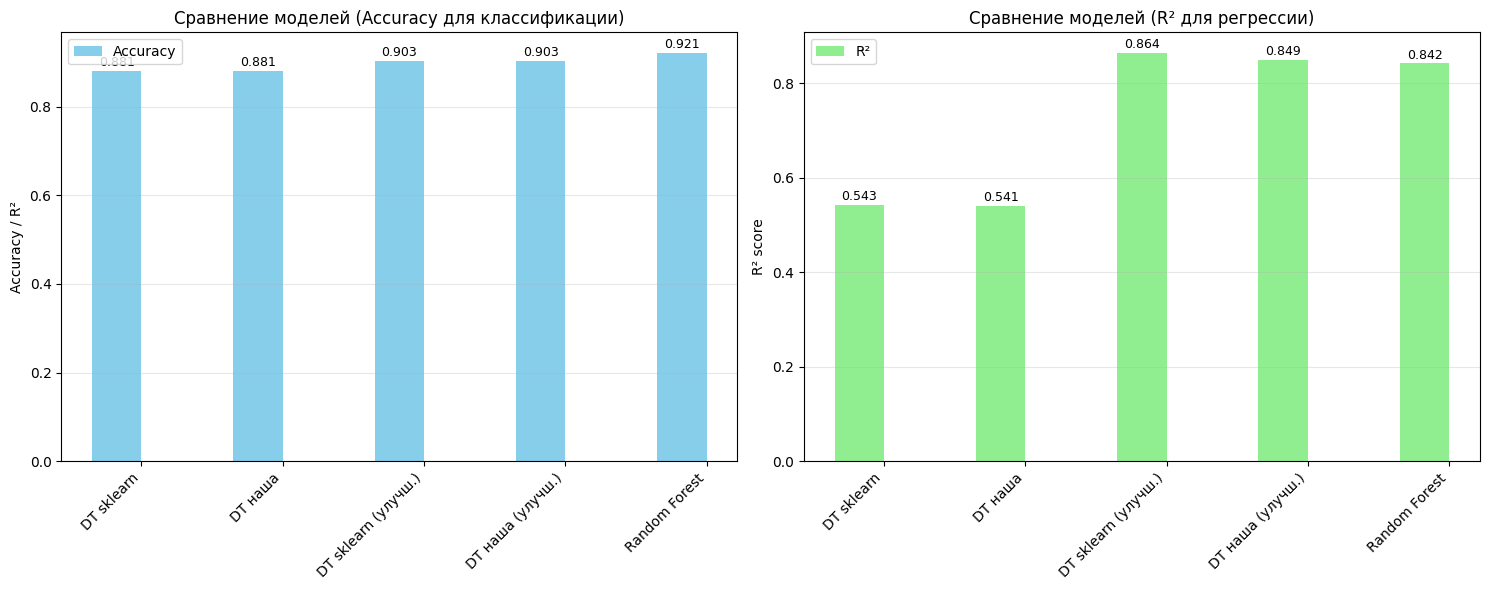

In [27]:
print("\n" + "="*70)
print("ИТОГОВОЕ СРАВНЕНИЕ ВСЕХ МОДЕЛЕЙ ДЕРЕВЬЕВ")
print("="*70)

print(f"\n{'Алгоритм':<30} {'Реализация':<15} {'Accuracy/R²':<15} {'F1/MAE (млн €)':<20}")
print(f"{'-'*30:<30} {'-'*15:<15} {'-'*15:<15} {'-'*20:<20}")

print(f"\n{'DecisionTreeClassifier':<30} {'sklearn (бейз)':<15} {acc_dt_cls:<15.4f} {f1_dt_cls:<20.4f}")
if 'acc_dt_cls_imp' in locals():
    print(f"{'':<30} {'sklearn (улучш)':<15} {acc_dt_cls_imp:<15.4f} {f1_dt_cls_imp:<20.4f}")
print(f"{'':<30} {'своя (бейз)':<15} {acc_my_dt_cls:<15.4f} {f1_my_dt_cls:<20.4f}")
print(f"{'':<30} {'своя (улучш)':<15} {acc_my_dt_cls_imp:<15.4f} {f1_my_dt_cls_imp:<20.4f}")

print(f"\n{'DecisionTreeRegressor':<30} {'sklearn (бейз)':<15} {r2_dt_reg:<15.4f} {mae_dt_reg/1_000_000:<20.2f}")
if 'r2_dt_reg_imp' in locals():
    print(f"{'':<30} {'sklearn (улучш)':<15} {r2_dt_reg_imp:<15.4f} {mae_dt_reg_imp/1_000_000:<20.2f}")
print(f"{'':<30} {'своя (бейз)':<15} {r2_my_dt_reg:<15.4f} {mae_my_dt_reg/1_000_000:<20.2f}")
print(f"{'':<30} {'своя (улучш)':<15} {r2_my_dt_reg_imp:<15.4f} {mae_my_dt_reg_imp/1_000_000:<20.2f}")

if 'acc_rf_cls' in locals():
    print(f"\n{'RandomForestClassifier':<30} {'sklearn':<15} {acc_rf_cls:<15.4f} {f1_rf_cls:<20.4f}")
if 'r2_rf_reg' in locals():
    print(f"{'RandomForestRegressor':<30} {'sklearn':<15} {r2_rf_reg:<15.4f} {mae_rf_reg/1_000_000:<20.2f}")

print("\n" + "="*70)
print("ВИЗУАЛИЗАЦИЯ СРАВНЕНИЯ МОДЕЛЕЙ")
print("="*70)

# Создаем график сравнения
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Подготовка данных для графиков
models_comparison = []
accuracy_scores = []
r2_scores = []

# Добавляем модели, которые у нас есть
models_comparison.append('DT sklearn')
accuracy_scores.append(acc_dt_cls)
r2_scores.append(r2_dt_reg)

models_comparison.append('DT наша')
accuracy_scores.append(acc_my_dt_cls)
r2_scores.append(r2_my_dt_reg)

if 'acc_dt_cls_imp' in locals():
    models_comparison.append('DT sklearn (улучш.)')
    accuracy_scores.append(acc_dt_cls_imp)
    r2_scores.append(r2_dt_reg_imp)

models_comparison.append('DT наша (улучш.)')
accuracy_scores.append(acc_my_dt_cls_imp)
r2_scores.append(r2_my_dt_reg_imp)

if 'acc_rf_cls' in locals():
    models_comparison.append('Random Forest')
    accuracy_scores.append(acc_rf_cls)
    r2_scores.append(r2_rf_reg)

# График для классификации
x_pos = np.arange(len(models_comparison))
width = 0.35

axes[0].bar(x_pos - width/2, accuracy_scores, width, label='Accuracy', color='skyblue')
axes[0].set_ylabel('Accuracy / R²')
axes[0].set_title('Сравнение моделей (Accuracy для классификации)')
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(models_comparison, rotation=45, ha='right')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Добавляем значения на столбцы
for i, v in enumerate(accuracy_scores):
    axes[0].text(i - width/2, v + 0.01, f'{v:.3f}', ha='center', fontsize=9)

# График для регрессии
axes[1].bar(x_pos - width/2, r2_scores, width, label='R²', color='lightgreen')
axes[1].set_ylabel('R² score')
axes[1].set_title('Сравнение моделей (R² для регрессии)')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(models_comparison, rotation=45, ha='right')
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

# Добавляем значения на столбцы
for i, v in enumerate(r2_scores):
    axes[1].text(i - width/2, v + 0.01, f'{v:.3f}', ha='center', fontsize=9)

plt.tight_layout()
plt.show()
